<font size="5">Customer Segmentation & Profiling</font>

<br />

**In progress**

In this project, customer clusters are analyzed in order to profile the characteristics of each cluster, with the ultimate goals of understanding how each cluster relates to key metrics like spending score and predicting the cluster of new leads.

<br />

<u>Business Challenge<u/>
- An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.
- In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them.
- You are tasked with creating a profile of each cluster's characteristics to help the management team better understand customer types.

<br />

<u>Data Notes<u/>
- Dataset contains 8068 customer records labelled for training, and 2627 test records
  - Data features consist of 10 customer attributes (numeric or categorical) of differing ranges
  - Data labels contain the provided/true cluster for each instance
  - Source (data + scenario): https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data

In [1]:
#Imports
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import seaborn.objects as so
import numpy as np

 #Configure pandas for high dimensionality dataframes
pd.set_option('display.max_columns', None)

In [2]:
#Load data + review attributes
df_train = pd.read_csv(r'C:\Users\Public\cust_train.csv')
#df_test = pd.read_csv(r'C:\Users\Public\cust_test.csv')
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None


In [3]:
#Preview data
df_train.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [4]:
#Remove ID column
cust_train = df_train.drop(df_train[['ID']], axis=1)

In [5]:
#Check label balance
cust_train['Segmentation'].value_counts(normalize=True)

Segmentation
D    0.281111
A    0.244422
C    0.244175
B    0.230293
Name: proportion, dtype: float64

In [6]:
#Count missing values
cust_train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
#Drop records with missing values
cust_train = cust_train.dropna()
print("Records after dropping missing values: "+str(len(cust_train)))

Records after dropping missing values: 6665


In [8]:
#Updated balance
cust_train['Segmentation'].value_counts(normalize=True)

Segmentation
D    0.263616
C    0.258065
A    0.242461
B    0.235859
Name: proportion, dtype: float64

In [9]:
#Updated attributes
cust_train.info()
print(cust_train.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6665 non-null   object 
 1   Ever_Married     6665 non-null   object 
 2   Age              6665 non-null   int64  
 3   Graduated        6665 non-null   object 
 4   Profession       6665 non-null   object 
 5   Work_Experience  6665 non-null   float64
 6   Spending_Score   6665 non-null   object 
 7   Family_Size      6665 non-null   float64
 8   Var_1            6665 non-null   object 
 9   Segmentation     6665 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 572.8+ KB
(6665, 10)


In [10]:
cust_train.head(2)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [11]:
#Reset index
cust_train.reset_index(drop=True, inplace=True)

In [12]:
#Feature df for memory comparison
feats_df = cust_train.drop(cust_train[['Segmentation']], axis=1)

In [13]:
#Convert float cols to int
cust_train = cust_train.astype({'Work_Experience':int, 'Family_Size':int})
cust_train.head(2)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,Low,4,Cat_4,D
1,Female,Yes,67,Yes,Engineer,1,Low,1,Cat_6,B


In [14]:
#Detect categorical columns
obj_tr = (cust_train.dtypes == 'object')
obj_cols_tr = list(obj_tr[obj_tr].index)
obj_cols_tr

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

In [15]:
#List categories and levels
cat_count=0
for col in obj_cols_tr:
    print(pd.DataFrame(cust_train[col].value_counts()))
    cat_count += len(cust_train[col].value_counts())
print('\nTotal # categorical levels/values: ', cat_count)

        count
Gender       
Male     3677
Female   2988
              count
Ever_Married       
Yes            3944
No             2721
           count
Graduated       
Yes         4249
No          2416
               count
Profession          
Artist          2192
Healthcare      1077
Entertainment    809
Doctor           592
Engineer         582
Executive        505
Lawyer           500
Marketing        233
Homemaker        175
                count
Spending_Score       
Low              3999
Average          1662
High             1004
       count
Var_1       
Cat_6   4476
Cat_4    849
Cat_3    634
Cat_2    362
Cat_7    166
Cat_1    104
Cat_5     74
              count
Segmentation       
D              1757
C              1720
A              1616
B              1572

Total # categorical levels/values:  29


In [16]:
#Encode categorical variables depending on relationships between values

 #LabelEncoder for label ('Segmentation'); maps labels alphabetically (A=0, D=3)
enc_lab = LabelEncoder()
 #OrdinalEncoder for 'Spending_Score
  #Assign Spend_Score categories to continuous values; Low=1, high=3
enc_ord = OrdinalEncoder(categories=[['skip','Low','Average','High']])
 #OneHotEncoder for remaining categorical features
enc_OneH = OneHotEncoder(sparse_output=False, dtype=int)

In [17]:
cust_enc = cust_train.copy()

 #Encode labels
cust_enc['Segmentation'] = enc_lab.fit_transform(cust_enc['Segmentation'])
 #Encode 'Spending_Score'
cust_enc['Spending_Score'] = enc_ord.fit_transform(cust_enc[['Spending_Score']]).astype(int)

cust_enc.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,1,4,Cat_4,3
1,Female,Yes,67,Yes,Engineer,1,1,1,Cat_6,1
2,Male,Yes,67,Yes,Lawyer,0,3,2,Cat_6,1


Before transforming the remaining categorical columns into one-hot columns, lets look at a scatter matrix of the numeric features

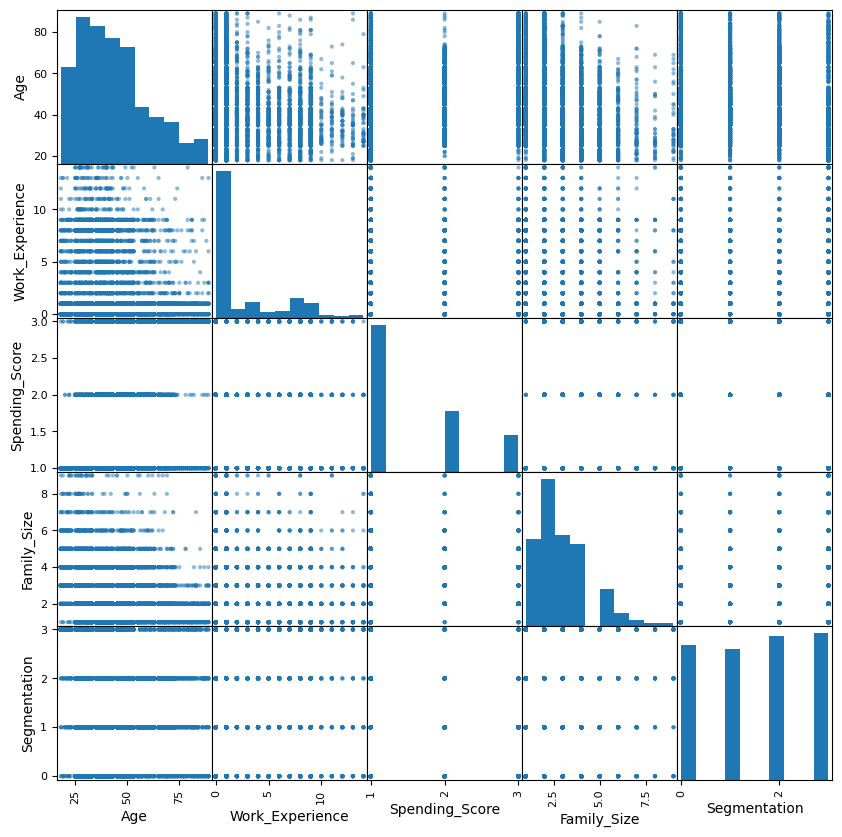

In [18]:
pd.plotting.scatter_matrix(cust_enc, grid=True, figsize=(10,10))
plt.show()

In [19]:
#Remaining categorical vars (not label or ordinal)
cols_rem = [col for col in obj_cols_tr if col not in ['Spending_Score', 'Segmentation']]
cols_rem

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']

In [20]:
#Encode features in dataframe
cats_enc = pd.DataFrame(enc_OneH.fit_transform(cust_enc[cols_rem]), columns=enc_OneH.get_feature_names_out())
 #Preview One-Hot features
print(cats_enc.shape)
cats_enc.head()

(6665, 22)


,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [21]:
#Combine original and one hot encoded dataframes
cust_enc = pd.concat([cust_enc, cats_enc], axis=1)
 #Drop pre-transformation features
cust_enc = cust_enc.drop(cust_enc[['Gender','Ever_Married','Graduated','Profession','Var_1']], axis=1)

In [22]:
#Move Label to last column
cust_enc['Segmentation'] = cust_enc.pop('Segmentation')

In [23]:
#Preview full pre-processed df
cust_enc.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,22,1,1,4,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3
1,67,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,67,0,3,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [24]:
#Review summary statistics
cust_enc.describe()

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
count,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000
mean,43.536084,2.629107,1.550638,2.841110,0.448312,0.551688,0.408252,0.591748,0.362491,0.637509,0.328882,0.088822,0.087322,0.121380,0.075769,0.161590,0.026257,0.075019,0.034959,0.015604,0.054314,0.095124,0.127382,0.011103,0.671568,0.024906,1.542836
std,16.524054,3.405365,0.740806,1.524743,0.497358,0.497358,0.491547,0.491547,0.480755,0.480755,0.469842,0.284508,0.282327,0.326593,0.264648,0.368102,0.159909,0.263441,0.183689,0.123946,0.226652,0.293408,0.333425,0.104791,0.469678,0.155851,1.122723
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,41.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,53.000000,4.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,89.000000,14.000000,3.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


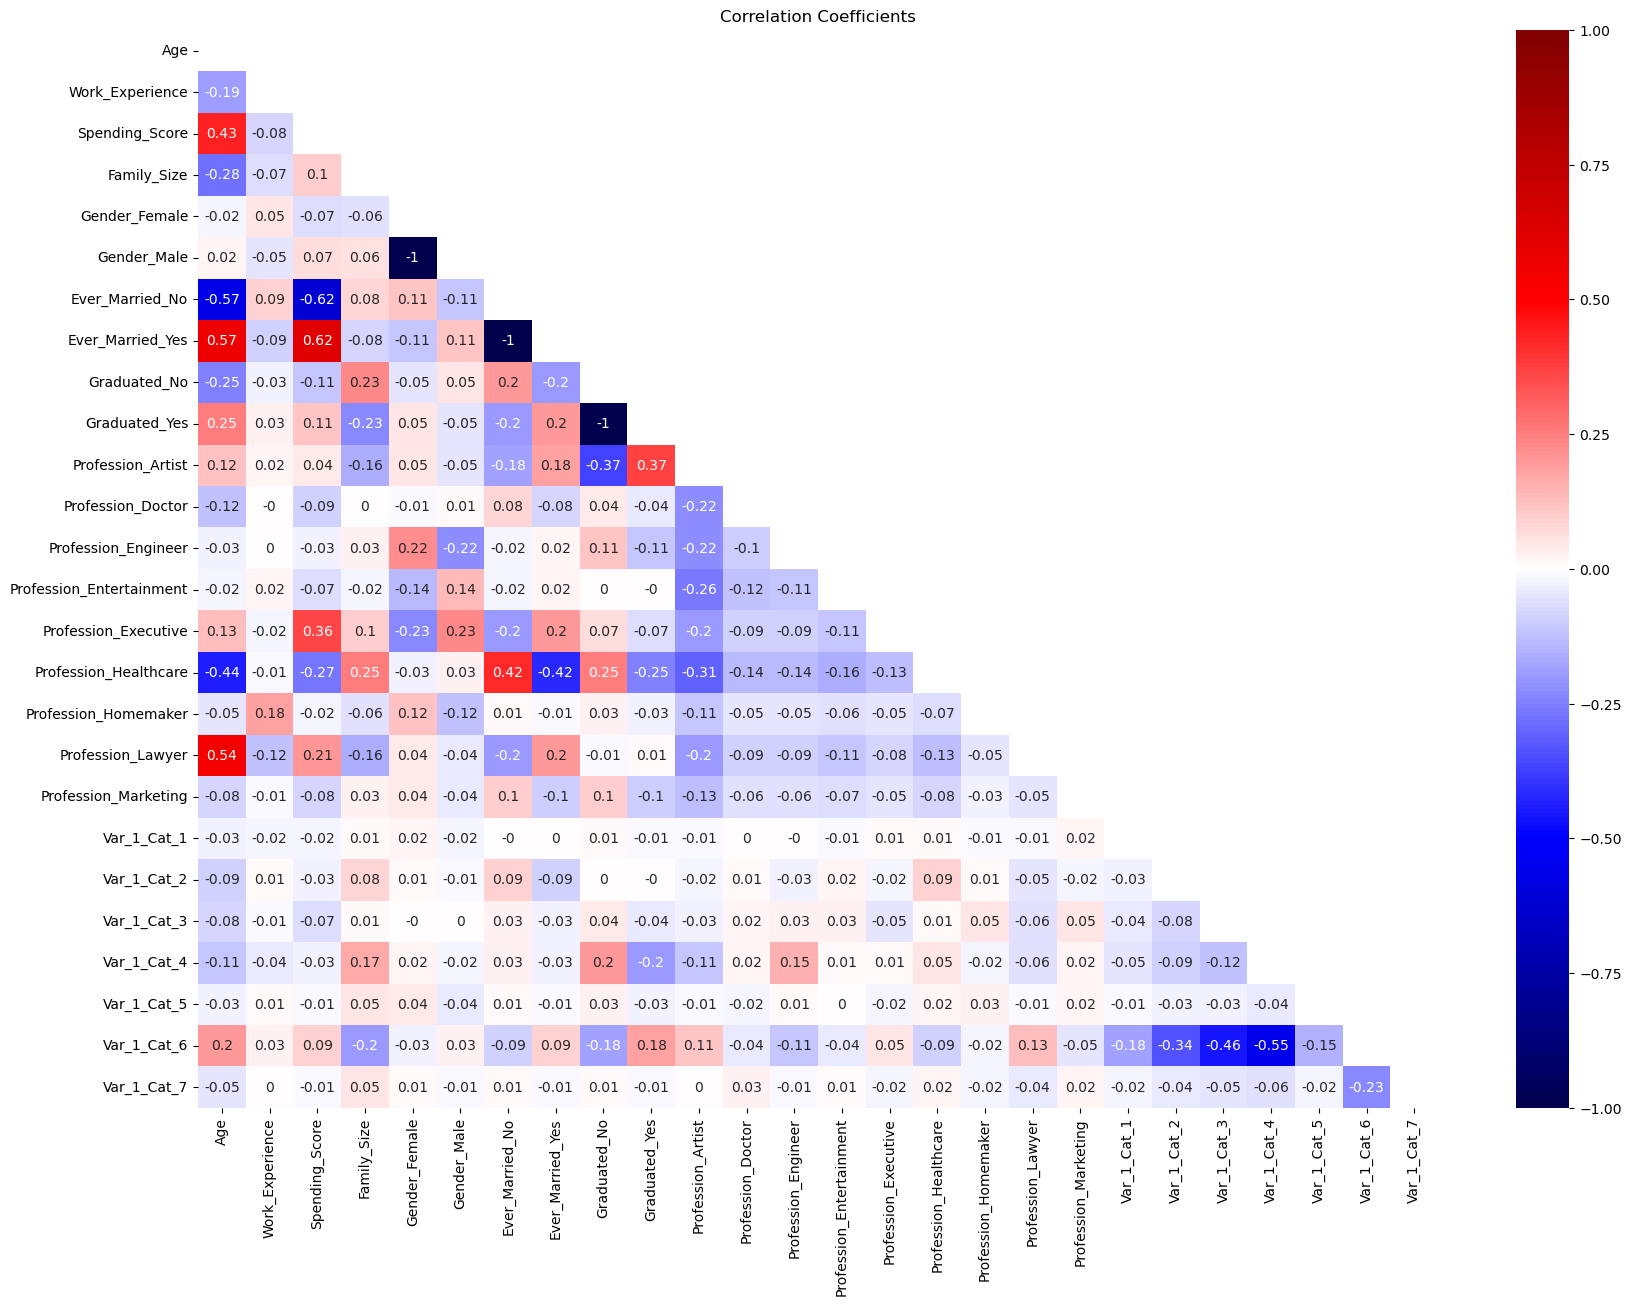

In [25]:
#Create correlation matrix
corr_df = cust_enc.copy()
corr_df = corr_df.drop(corr_df[['Segmentation']], axis=1)
corr_matrix = corr_df.corr().round(2)

#Plot masked heatmap
mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(20,14))

sns.heatmap(corr_matrix, annot=True, cmap='seismic', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients')
plt.show()

We can observe some simple associations in the correlation coefficients:
- Married people, lawyers, people who have graduated, and (to some degree) people in the anonymized Var_1 category '6' are correlated with greater ages
  - Healthcare workers tend to be younger
- Married people, lawyers, and exectives correlate with higher spending scores
  - Unmarried people and healthcare workers tend to spend less
 
Now lets scale the training data and split it into train/test sets

In [26]:
#Store + drop unscaled labels
cust_tr_seg = cust_enc['Segmentation']
cust_tr = cust_enc.drop(cust_train[['Segmentation']], axis=1)

In [27]:
#Save column names
col_names = pd.Series(cust_tr.columns)

#Scale data + reapply column titles
scaler = StandardScaler()
cust_tr_sc = pd.DataFrame(scaler.fit_transform(cust_tr))
cust_tr_sc.rename(columns=col_names, inplace=True)

In [28]:
#Concat unscaled labels
cust_tr_sc = pd.concat([cust_tr_sc, cust_tr_seg], axis=1)
cust_tr_sc.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,-1.303415,-0.478430,-0.743351,0.760113,-0.901454,0.901454,1.203938,-1.203938,1.326157,-1.326157,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,2.277825,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,2.617329,-0.10596,-1.429954,-0.15982,3
1,1.420092,-0.478430,-0.743351,-1.207580,1.109319,-1.109319,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,3.232938,-0.371684,-0.286322,-0.439015,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1
2,1.420092,-0.772106,1.956614,-0.551682,-0.901454,0.901454,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,-0.439015,-0.164209,3.511410,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,1


In [29]:
#Split labelled train data into train (6/7) and test (1/7) sets
split_index = len(cust_tr_sc)//7

y_tr = cust_tr_sc.iloc[:-split_index, -1:]
y_tr = y_tr.to_numpy().reshape(len(y_tr),)

X_tr = cust_tr_sc.iloc[:-split_index, :-1]

y_te = cust_tr_sc.iloc[-split_index:, -1:]
y_te = y_te.to_numpy().reshape(len(y_te),)

X_te = cust_tr_sc.iloc[-split_index:, :-1]

In [30]:
X_tr.shape, y_tr.shape

((5713, 26), (5713,))

In [31]:
X_te.shape, y_te.shape

((952, 26), (952,))

Let's try a Logistic Regression (supervised learning) using the scaled training features for a baseline measure of predictive accuracy.

In [32]:
#Fit + predict with LogReg model
base_log_reg = LogisticRegression(max_iter=2_500)
base_log_reg.fit(X_tr, y_tr)

base_score = base_log_reg.score(X_te, y_te)
print(base_score)

0.523109243697479


<br/>
Now we'll use Principal Component Analysis (unsupervised learning) to project our features onto a lower dimensional subspace, reducing the dimensionality of our dataset from 26.

First let's determine how many principal components are required to retain 99 & 95% of the features' variance.

In [33]:
#Fit and output variance explained by each component in df
pca = PCA()
pca.fit(X_tr)

expl_var = pca.explained_variance_ratio_
ex_var_df = pd.DataFrame(expl_var)
ex_var_df.rename(columns={0:'Explained Variance'}, inplace=True)
print(ex_var_df.shape)
ex_var_df.transpose()

(26, 1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Explained Variance,0.153388,0.096111,0.079942,0.063197,0.050856,0.048811,0.045325,0.043728,0.043194,0.040503,0.039127,0.038734,0.03843,0.03802,0.036114,0.034805,0.03043,0.029914,0.023477,0.015115,0.010779,2.790950e-33,2.063700e-33,1.913043e-33,6.515541e-34,2.522184e-34


In [34]:
#Array of cumulative variance explained by principal components, sorted greatest to least
cumulative_sum = np.cumsum(expl_var)
cumulative_sum

array([0.15338812, 0.24949898, 0.32944134, 0.39263828, 0.44349466,
       0.4923056 , 0.53763088, 0.58135859, 0.62455273, 0.66505599,
       0.7041834 , 0.74291739, 0.78134735, 0.8193676 , 0.8554812 ,
       0.89028597, 0.92071586, 0.95062962, 0.9741067 , 0.98922129,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In these sorted views we see a few things:
- The first 3 components account for about 15.3/9.6/8% of information/variance
- The last 5 components are many orders of magnitude smaller, and add almost no information
  - The 3 components before these account for about 2.3/1.5/1.1% variance

Let's calculate the number of components necessary to preserve 95 and 99% of the total variance.

In [35]:
#Calculate + store '# components' for 95/99% of variance in variable
dim_95 = np.argmax(cumulative_sum >= 0.95) + 1
dim_99 = np.argmax(cumulative_sum >= 0.99) + 1

print(str(dim_95)+'\n'+str(dim_99))

18
21


In [36]:
#Store all components
p_comps = pca.transform(X_tr)
p_comps[0]

array([ 3.72823527e+00,  2.10518895e+00, -2.63294584e-01, -4.06428555e-01,
       -2.95115279e-01, -1.36254056e+00, -5.74092308e-01, -5.83139308e-01,
        1.79438046e-01, -1.08926525e+00, -7.33852624e-01, -3.26632748e-01,
        7.85215717e-01,  1.06278759e+00,  8.88191226e-01, -5.13433943e-01,
        3.18503220e-02,  1.02170878e-01, -6.04178388e-01, -2.45798063e-01,
       -3.21177842e-02,  5.40374423e-17,  2.69915600e-16, -2.29355653e-17,
       -2.51424380e-16, -3.20238221e-17])

In [37]:
print(p_comps.shape)

(5713, 26)


In [38]:
#Create 95% and 99% variance sets
pc_95 = p_comps[:, :dim_95]
pc_99 = p_comps[:, :dim_99]
pc_95.shape, pc_99.shape

((5713, 18), (5713, 21))

Now let's use a more streamlined method

In [39]:
#Set desired variance retained at model instantiation
pca_99 = PCA(n_components=0.99)

In [40]:
#Create reduced/PCA-transformed datasets
X_tr_99 = pca_99.fit_transform(X_tr)

In [41]:
print(X_tr_99.shape)
X_tr_99[0]

(5713, 21)


array([ 3.72823527,  2.10518895, -0.26329458, -0.40642856, -0.29511528,
       -1.36254056, -0.57409231, -0.58313931,  0.17943805, -1.08926525,
       -0.73385262, -0.32663275,  0.78521572,  1.06278759,  0.88819123,
       -0.51343394,  0.03185032,  0.10217088, -0.60417839, -0.24579806,
       -0.03211778])

In [42]:
X_tr_95 = X_tr_99[:, :dim_95]
X_tr_95.shape

(5713, 18)

In [43]:
#Plot first 3 PC of reduced dataset
x = X_tr_99[:, 0]
y = X_tr_99[:, 1]
z = X_tr_99[:, 2]

 #Value ranges
print(min(x), max(x))
print(min(y), max(y))
print(min(z), max(z))

-3.8934802063200116 4.601642929666106
-3.388766646549818 5.069601484737699
-2.784079935460552 4.854862795352418


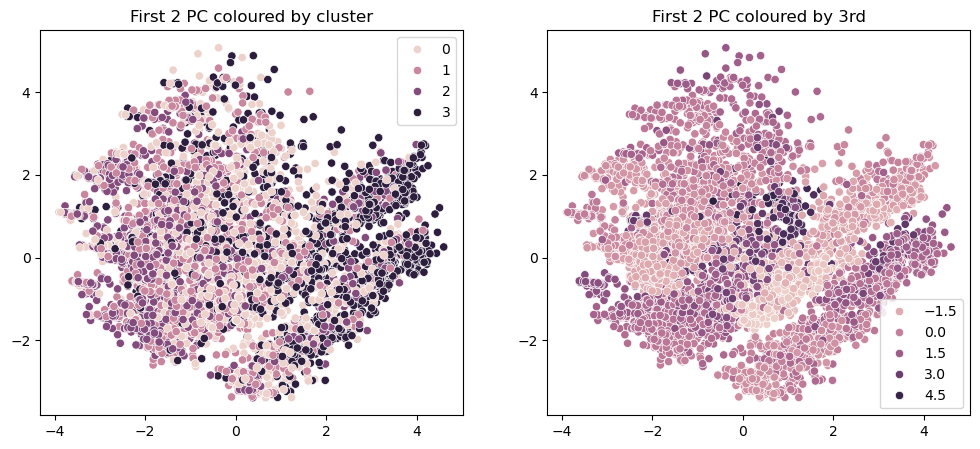

In [44]:
 #In 2 dimensions
fig, axes = plt.subplots(1, 2, figsize=(12,5))
  #First 2 principal components plotted in 2D, colored by cluster
sns.scatterplot(x=x, y=y, hue=y_tr, ax=axes[0])
axes[0].set_title('First 2 PC coloured by cluster')
  #First 2 principal components plotted in 2D, colored by 3rd PC
sns.scatterplot(x=x, y=y, hue=z, ax=axes[1])
axes[1].set_title('First 2 PC coloured by 3rd')
plt.show()

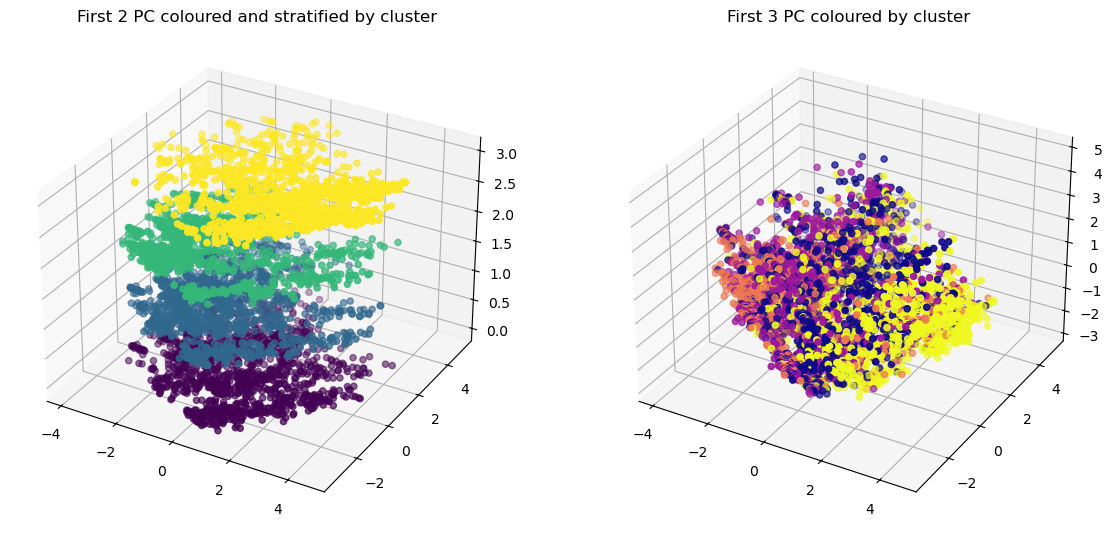

In [45]:
 #In 3 dimensions
  #First 2 principal components in 3D subspace, coloured and stratified vertically by cluster
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(14,12))
axes[0].scatter(x, y, y_tr, c=y_tr, marker="o")
axes[0].set_title("First 2 PC coloured and stratified by cluster")
  #First 3 principal components in 3D subspace, coloured by cluster
axes[1].scatter(x, y, z, c=y_tr, cmap='plasma', marker="o")
axes[1].set_title("First 3 PC coloured by cluster")
plt.show()

On the left we can visualize how when reduced to 2 principal components (explaining ~25% of variance), the instances in each layer seem to occupy somewhat characteristic regions but aren't very distinct, having much overlap.

On the right we can visualize how the first 3 principal components (explaining ~33% of variance) begin to show discernible groupings.

<br/>

Now that we've reduced the dimensionality of the dataset and explored the principal components, we can evaluate the memory savings and how the principal components perform in predicting our four labels.

In [46]:
orig_mem = feats_df.memory_usage().sum()/1024
enc_mem = cust_tr.memory_usage().sum()/1024
scaled_mem = X_tr.memory_usage().sum()/1024
pc_95_mem = pd.DataFrame(X_tr_95).memory_usage().sum()/1024
pc_99_mem = pd.DataFrame(X_tr_99).memory_usage().sum()/1024

print('9 original features memory usage: '+str({}).format(round(orig_mem, 2))+' KB')
print('26 encoded features memory usage: '+str({}).format(round(enc_mem, 2))+' KB')
print('26 scaled features memory usage: '+str({}).format(round(scaled_mem, 2))+' KB')
print('18 Principal Components (95% var) memory usage: '+str({}).format(round(pc_95_mem, 2))+' KB')
print('21 Principal Components (99% var) memory usage: '+str({}).format(round(pc_99_mem, 2))+' KB')

9 original features memory usage: 468.76 KB
26 encoded features memory usage: 703.07 KB
26 scaled features memory usage: 1160.58 KB
18 Principal Components (95% var) memory usage: 803.52 KB
21 Principal Components (99% var) memory usage: 937.41 KB


In [47]:
#Create models + fit principal components
log_reg_95 = LogisticRegression(max_iter=2_500)
log_reg_99 = LogisticRegression(max_iter=2_500)

log_reg_95.fit(X_tr_95, y_tr)
log_reg_99.fit(X_tr_99, y_tr)

#Transform test set into PCA-reduced sets
X_te_99 = pca_99.transform(X_te)
X_te_95 = X_te_99[:, :dim_95]

#Predict with LogReg models
pc_95_score = log_reg_95.score(X_te_95, y_te)
pc_99_score = log_reg_99.score(X_te_99, y_te)

print('Accuracy with 18/26 PC:', pc_95_score)
print('Accuracy with 21/26 PC:', pc_99_score)

Accuracy with 18/26 PC: 0.5147058823529411
Accuracy with 21/26 PC: 0.523109243697479


In [48]:
#Calculate memory + accuracy changes
delta_mem_95 = pc_95_mem/scaled_mem*100
delta_mem_99 = pc_99_mem/scaled_mem*100

delta_acc_95 = pc_95_score/base_score*100
delta_acc_99 = pc_99_score/base_score*100

#Output in %
print('95% var PC\'s vs scaled features memory proportion: {}'.format(round(delta_mem_95))+'%')
print('99% var PC\'s vs scaled features memory proportion: {}'.format(round(delta_mem_99))+'%')
print('95% var PC\'s vs scaled data LogReg accuracy proportion: {}'.format(round(delta_acc_95))+'%')
print('99% var PC\'s vs scaled data LogReg accuracy proportion: {}'.format(round(delta_acc_99))+'%')

95% var PC's vs scaled features memory proportion: 69%
99% var PC's vs scaled features memory proportion: 81%
95% var PC's vs scaled data LogReg accuracy proportion: 98%
99% var PC's vs scaled data LogReg accuracy proportion: 100%


While all transformations increased the size of the original feature set:
- Applying PCA (at 99% retained variance) to the scaled features reduced dimensionality from 26 to 21 and memory to ~81% of its former size, while retaining the original accuracy.
- For PCA with 95% retained variance, 98% of original accuracy and an additional 12% memory size reduction was achieved with only 18 dimensions.

<br/>

Next, we'll analyze the characteristics of the clusters the sales team created using our interpretable features.

In [49]:
int_df = cust_train.copy()
int_df.rename(columns={'Segmentation':'Segment'}, inplace=True)
print(int_df.shape)

(6665, 10)


In [50]:
clusterA = int_df[int_df['Segment']=='A']
clusterB = int_df[int_df['Segment']=='B']
clusterC = int_df[int_df['Segment']=='C']
clusterD = int_df[int_df['Segment']=='D']

clusters = [clusterA, clusterB, clusterC, clusterD]

print(clusterA.shape, clusterB.shape, clusterC.shape, clusterD.shape)
clusterA.head(2)

(1616, 10) (1572, 10) (1720, 10) (1757, 10)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segment
8,Female,No,26,Yes,Engineer,1,Low,3,Cat_6,A
16,Male,Yes,49,Yes,Homemaker,12,Low,1,Cat_3,A


Let's start by looking at the ages of our clusters within each spending level

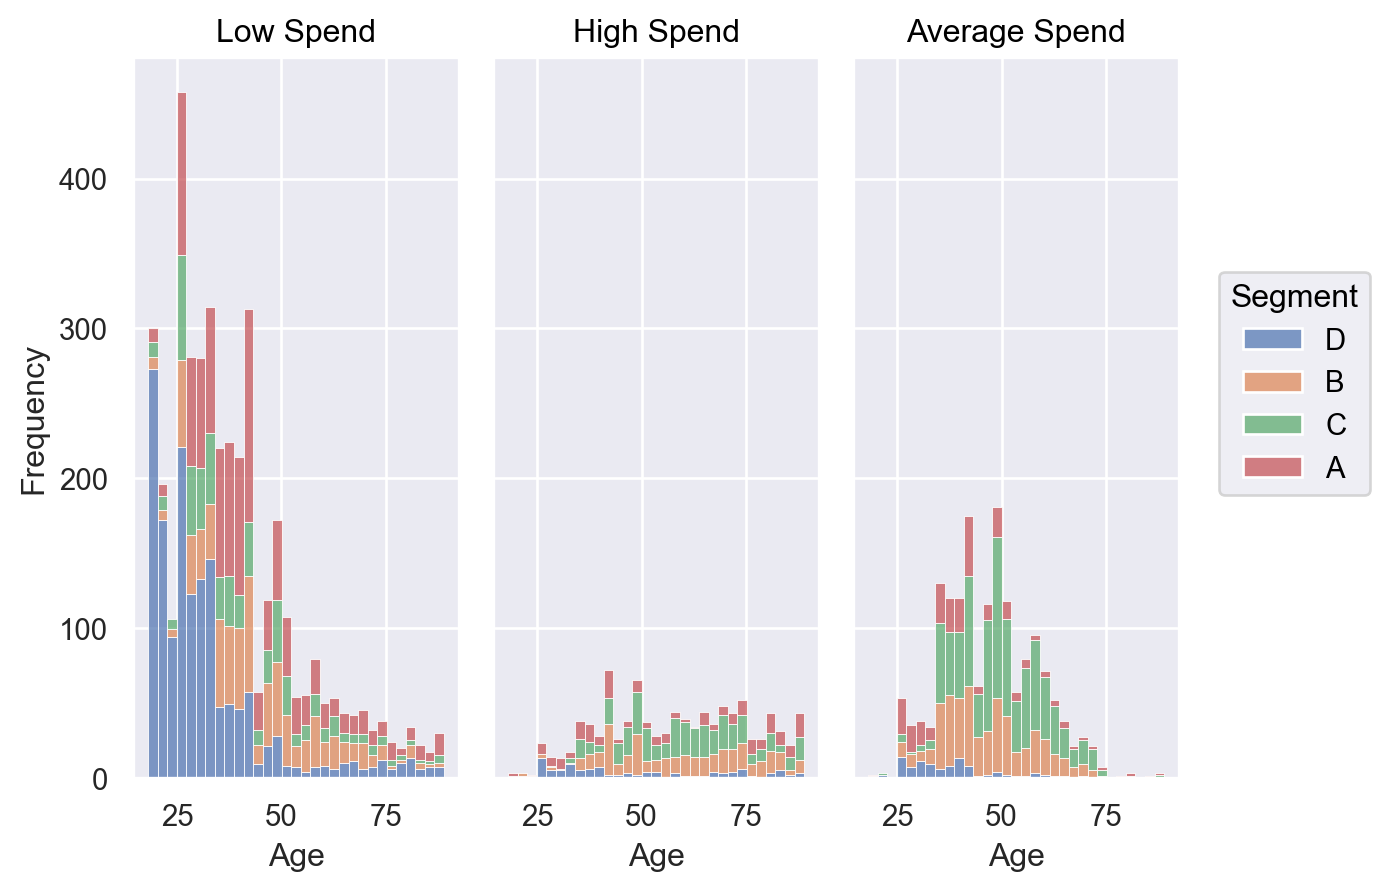

In [51]:
plot1 = (
    so.Plot(int_df, x='Age', color='Segment')
    .facet('Spending_Score')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot1.label(y='Frequency', title='{} Spend'.format)

D appears to be the youngest cluster, being almost entirely under 50; D is also predominantly in the low spend category.

While this plot suggests some age-related differences between clusters, we can evaluate the age distributions statistically:

In [52]:
print('Cluster A:\n', clusterA.describe())
print('Cluster B:\n', clusterB.describe())
print('Cluster C:\n', clusterC.describe())
print('Cluster D:\n', clusterD.describe())

Cluster A:
                Age  Work_Experience  Family_Size
count  1616.000000      1616.000000  1616.000000
mean     44.421411         2.888614     2.431931
std      16.173020         3.627206     1.479794
min      18.000000         0.000000     1.000000
25%      33.000000         0.000000     1.000000
50%      40.000000         1.000000     2.000000
75%      51.000000         5.000000     3.000000
max      89.000000        14.000000     9.000000
Cluster B:
                Age  Work_Experience  Family_Size
count  1572.000000      1572.000000  1572.000000
mean     48.113232         2.393766     2.682570
std      14.693990         3.246823     1.411195
min      18.000000         0.000000     1.000000
25%      38.000000         0.000000     2.000000
50%      46.000000         1.000000     2.000000
75%      58.000000         4.000000     4.000000
max      89.000000        14.000000     9.000000
Cluster C:
                Age  Work_Experience  Family_Size
count  1720.000000      1720.0000

In"D"eed, 50% of cluster D customers are between 22 and 37 years old, compared to 50% between 33-51 in cluster A and ~38-59 in clusters B and C.

Let's look at family sizes.

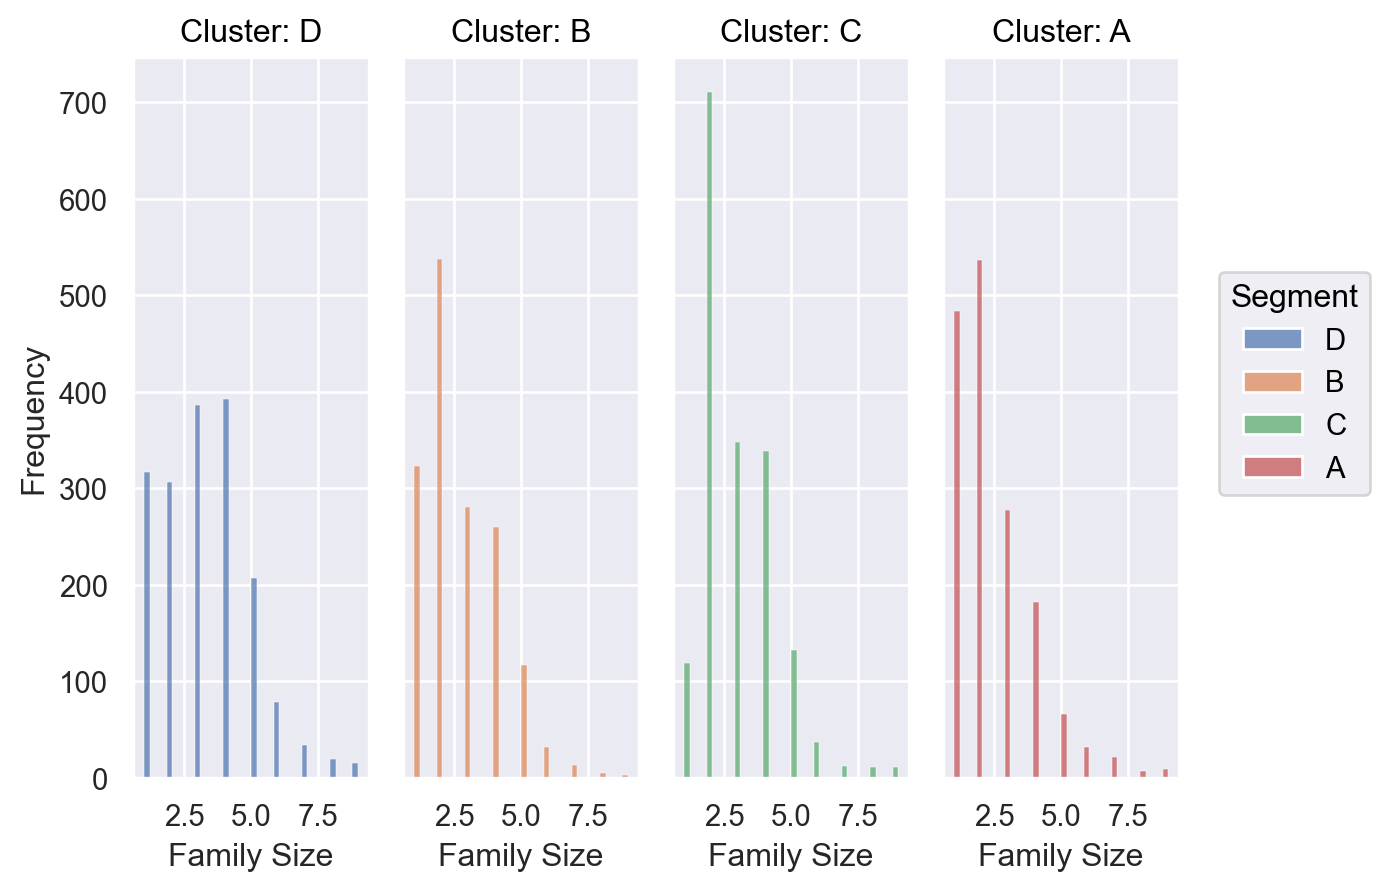

In [53]:
plot2 = (
    so.Plot(int_df, x='Family_Size', color='Segment')
    .facet('Segment')
    .add(so.Bars(), so.Hist(), so.Stack())
)
plot2.label(x='Family Size', y='Frequency', col='Cluster:')

Cluster C has just over 700 customers with a family size of 2.
- This might be a discerning characteristic, but clusters A and B also appear to have a high proportion of 2 person families (while D appears to have the most families of 6 or more).
  
Let's evaluate the proportions statistically.

In [54]:
print('Cluster A:\n', clusterA.Family_Size.value_counts(normalize=True))
print('Cluster B:\n', clusterB.Family_Size.value_counts(normalize=True))
print('Cluster C:\n', clusterC.Family_Size.value_counts(normalize=True))
print('Cluster D:\n', clusterD.Family_Size.value_counts(normalize=True))

Cluster A:
 Family_Size
2    0.332302
1    0.299505
3    0.171411
4    0.112624
5    0.040842
6    0.019802
7    0.013614
9    0.005569
8    0.004332
Name: proportion, dtype: float64
Cluster B:
 Family_Size
2    0.342239
1    0.205471
3    0.178753
4    0.165394
5    0.074427
6    0.020356
7    0.008270
8    0.003181
9    0.001908
Name: proportion, dtype: float64
Cluster C:
 Family_Size
2    0.413372
3    0.202326
4    0.197093
5    0.076744
1    0.069186
6    0.021512
7    0.006977
8    0.006395
9    0.006395
Name: proportion, dtype: float64
Cluster D:
 Family_Size
4    0.223677
3    0.219693
1    0.180421
2    0.174730
5    0.117814
6    0.044963
7    0.019351
8    0.010814
9    0.008537
Name: proportion, dtype: float64


Cluster C is 41% made up of 2-person families, the highest of any cluster by about 7%.

Cluster D also has double the proportion of 6 person families compared to other clusters.